# Getting Data

In [1]:
import flaph.webscrapping as ws
from secrets.secrets import APP_ID, APP_KEY

In [2]:
# Need id and key first
cykey = "_app_id=" + APP_ID + "&_app_key=" + APP_KEY
scuisine1 = "&allowedCuisine[]=cuisine^cuisine-" + "chinese"
scourse = "&allowedCourse[]=course^course-Main Dishes"
sresults = "&maxResult=" + str(500)
#build inital dataframe
yum = ws.initial_df(cykey,scuisine1,scourse,sresults)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

# Classifying Recipes
Start from cleaned data.

In [1]:
import flaph.recipe_classification as rc
import pandas as pd
%load_ext autoreload
%autoreload 2

/home/mholub/miniconda3/envs/food/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence
/home/mholub/miniconda3/envs/food/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/mholub/miniconda3/envs/food/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", Dep

In [ ]:
yum_clean = pd.read_pickle('data/yummly_clean.pkl')

#create a set of all ingredients in the dataframe
yum_ingredients=set()
yum_clean['clean ingredients'].map(lambda x: [yum_ingredients.add(i) for i in x])
print(len(yum_ingredients))

#create one column for each ingredient, True or False

yum = yum_clean.copy()
for item in yum_ingredients:
    yum[item] = yum['clean ingredients'].apply(lambda x:item in x)
yum_X = yum.drop(yum_clean.columns,axis=1)

#### test various classification models

In [31]:
rc.logistic_test(yum_X, yum['cuisine'])
#C=1 gave the best result, accuracy 0.69

First round: 0.6935769004124926
C= 0.01 ,score= 0.5521508544490277
C= 0.1 ,score= 0.6529169121979964
C= 1.0 ,score= 0.6935769004124926
C= 10.0 ,score= 0.6788450206246317
C= 100.0 ,score= 0.6629345904537419


In [32]:
rc.svm_test(yum_X,yum['cuisine'])
#linear svm C=0.1 gave the best result, accuracy 0.70

First round: 0.6753093694755451
C= 0.01 ,score= 0.6717737183264585
C= 0.1 ,score= 0.7030053034767236
C= 1.0 ,score= 0.6753093694755451
C= 10.0 ,score= 0.6258102533883324
C= 100.0 ,score= 0.5804360636417207


In [34]:
rc.nb_test(yum_X,yum['cuisine'])
#accuracy is 0.64

0.648202710665881
alpha= 0 ,score= 0.6140247495580436


/home/mholub/miniconda3/envs/food/lib/python3.7/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


alpha= 1.0 ,score= 0.648202710665881
alpha= 1.7782794100389228 ,score= 0.624042427813789
alpha= 3.1622776601683795 ,score= 0.5963464938126105
alpha= 5.623413251903491 ,score= 0.5662934590453742
alpha= 10.0 ,score= 0.5344725987035945


In [36]:
rc.rf_test(yum_X,yum['cuisine'])
#accuracy is 0.64

0.657631113730112


#### Visualize quality of classification

In [ ]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

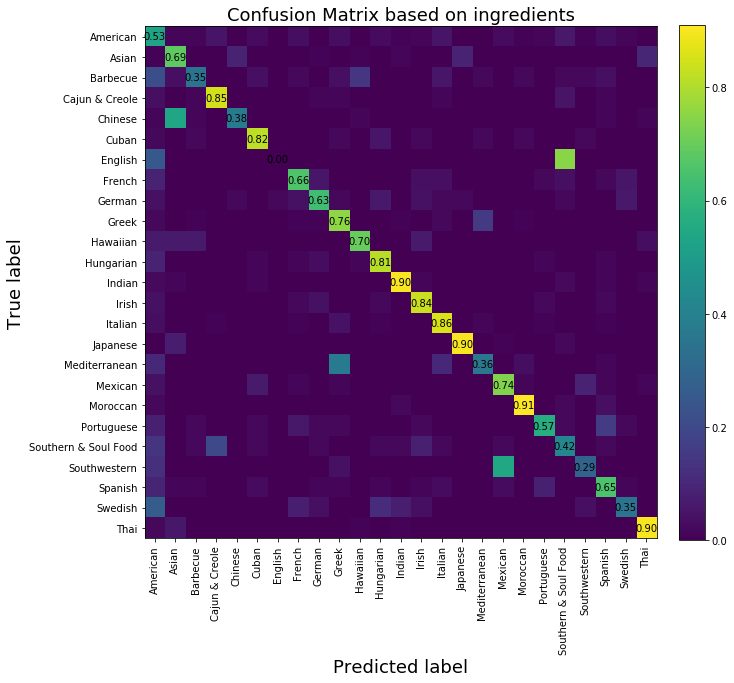

In [39]:
#plot confusion_matrix with svm
X = yum_X.values
y = yum['cuisine']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=10)
model = svm.LinearSVC(C=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,10))
rc.plot_confusion_matrix(cm_normalized, yum['cuisine'],title='Confusion Matrix based on ingredients')

In [47]:
import flaph.recipe_cleanup as cleanup

#load ingr and comp information for the flavor network
comp = pd.read_csv('data/comp_info.tsv',index_col=0,sep='\t')
ingr_comp = pd.read_csv('data/ingr_comp.tsv',sep='\t')
ingr = pd.read_csv('data/ingr_info.tsv',index_col=0,sep='\t')
ingr['space ingredients']= ingr['ingredient name'].apply(lambda x: x.replace('_',' ') )
ingr_ingredients = set()
ingr['space ingredients'].map(lambda x: ingr_ingredients.add(x))
print(len(ingr_ingredients))

yum_ingr = pd.read_pickle('data/yummly_ingr.pkl')
yum_X = pd.read_pickle('data/yummly_ingrX.pkl')
yum_flavor = cleanup.flavor_profile(yum_X, ingr, comp, ingr_comp)
yum_tfidf = cleanup.make_tfidf(yum_flavor)
pd.DataFrame(yum_flavor).to_pickle('data/yummly_flavor.pkl')
pd.DataFrame(yum_tfidf).to_pickle('data/yummly_tfidf.pkl')

1530
349 349
(6242, 349) (6242, 1107)
(6242, 1107)


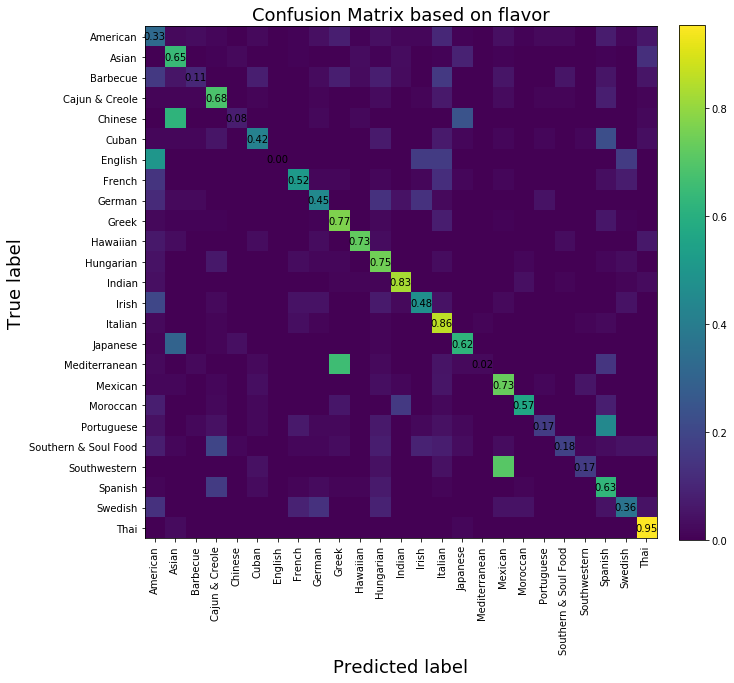

In [51]:
from sklearn.linear_model import LogisticRegression
#read pickled dataframe
yum_tfidf = pd.read_pickle('data/yummly_tfidf.pkl')
#plot confusion matrix for flavor-based classification
X = yum_tfidf.values
y = yum_ingr['cuisine']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=10)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,10))
rc.plot_confusion_matrix(cm_normalized, yum_ingr['cuisine'],title='Confusion Matrix based on flavor')

# Cluster Recipes

In [55]:
import flaph.recipe_clustering as rclust
yum_ingr = pd.read_pickle('data/yummly_ingr.pkl')
yum_ingrX = pd.read_pickle('data/yummly_ingrX.pkl')
yum_tfidf = pd.read_pickle('data/yummly_tfidf.pkl')

(1230, 349) [0, 384, 590, 942, 1230]


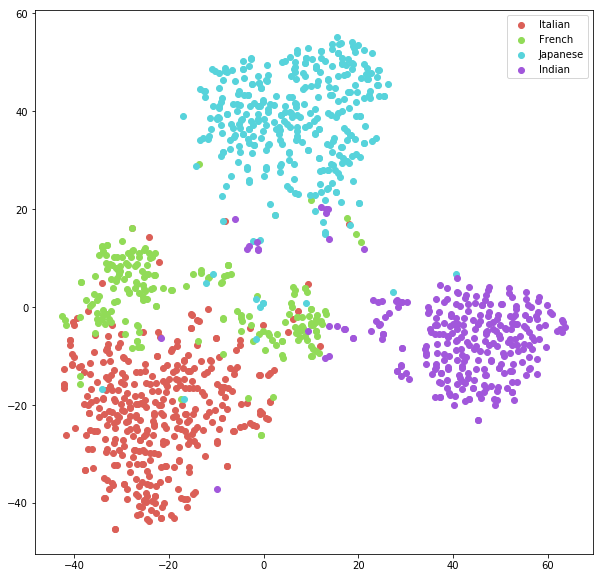

In [56]:
#select four cuisines and plot tsne clustering with ingredients
sublist = ['Italian','French','Japanese','Indian']
df_ingr = yum_ingrX.copy()
df_ingr['cuisine'] = yum_ingr['cuisine']
df_ingr['recipeName'] = yum_ingr['recipeName']
rclust.tsne_cluster_cuisine(df_ingr,sublist)

(1225, 1107) [0, 381, 587, 939, 1225]


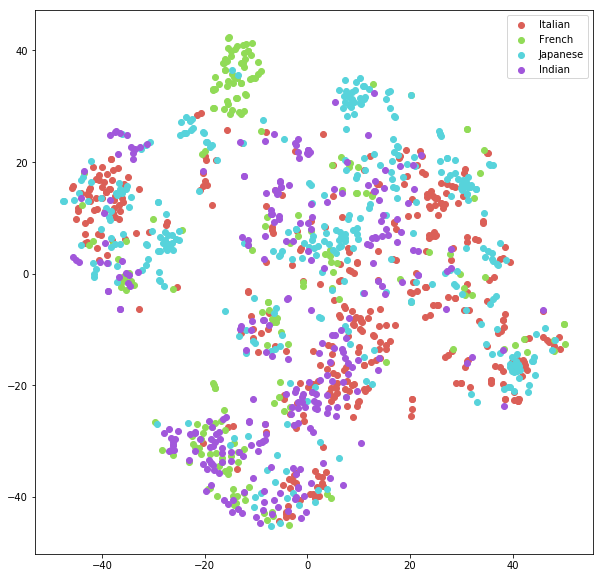

In [61]:
#select four cuisines and plot tsne clustering with flavor
sublist = ['Italian','French','Japanese','Indian']
df_flavor = yum_tfidf.copy()
df_flavor['cuisine'] = yum_ingr['cuisine']
df_flavor['recipeName'] = yum_ingr['recipeName']
rclust.tsne_cluster_cuisine(df_flavor,sublist)

# Recipe Recommendation

In [37]:
import flaph.recipe_recommendation as rrec
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances

yum_ingr = pd.read_pickle('data/yummly_ingr.pkl')
yum_ingrX = pd.read_pickle('data/yummly_ingrX.pkl')
yum_tfidf = pd.read_pickle('data/yummly_tfidf.pkl')

#calculate cosine similarity
yum_cos = cosine_similarity(yum_tfidf)

In [38]:
recipes = yum_ingr["recipeName"].values

In [43]:
seen_recipes = dict()
lrecipes = recipes.tolist()
duplicated_recipes = set([x for x in lrecipes if lrecipes.count(x) > 1])
for i,r in enumerate(recipes):
    if r not in seen_recipes.keys():
        seen_recipes[r] = 1
        if r in duplicated_recipes:
            recipes[i] = recipes[i] + "1"                       
    else:
        seen_recipes[r] += 1
        recipes[i] = recipes[i] + str(seen_recipes[r]) 

In [45]:
yum_ingr["recipeName"] = recipes

In [44]:
alpha = 1.0
beta = 0.75
yum_cos2 = pairwise_distances(yum_ingrX, metric = "jaccard")
metric = alpha * yum_cos2[idx] - beta * yum_cos[idx]

In [22]:
import random
recipes = yum_ingr["recipeName"].values
this_recipe = random.choice(recipes)
idx = [i for i,x in enumerate(recipes) if x == this_recipe][0]
print("recipe: {}, idx: {}".format(this_recipe, idx))

recipe: Greek Panzanella Salad, idx: 2449


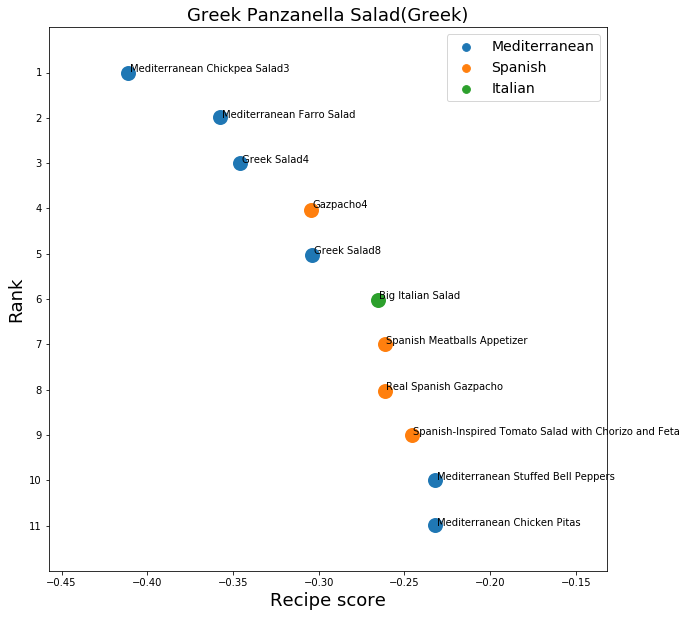

In [50]:
#plot similar dishes for idx
_ = rrec.plot_dishes(yum_ingr, yum_ingrX, yum_cos,idx, num = 10)

In [28]:
yum_ingr.loc[yum_ingr["recipeName"] == "Greek Panzanella Salad", :]["clean ingredients"].values[0]

['olive oil',
 'french bread',
 'kosher salt',
 'hothouse cucumber',
 'red bell pepper',
 'yellow bell pepper',
 'cherry tomato',
 'purple onion',
 'feta cheese',
 'calamata olive',
 'garlic',
 'dried oregano',
 'dijon mustard',
 'red wine vinegar',
 'salt',
 'ground black pepper']

In [52]:
yum_ingr.loc[yum_ingr["recipeName"] == "Mediterranean Chickpea Salad3", :]["clean ingredients"].values.tolist()

[['olive oil',
  'red wine vinegar',
  'fresh lemon juice',
  'garlic',
  'dried oregano',
  'salt',
  'pepper',
  'chickpea',
  'english cucumber',
  'cherry tomato',
  'purple onion',
  'feta cheese crumbles',
  'red bell pepper',
  'fresh dill']]

---

## Notes

- Apparently, we would need a way how to deal with multiple entries. But for now, let's not bother.

In [138]:
import re
rgx = re.compile(".*mojito.*", flags = re.IGNORECASE)
list(filter(rgx.match, recipes))

['Minty Lime Frozen Mojito',
 'The Ultimate Mojito',
 'Cuban Mojito',
 'Cranberry Mojitos',
 'Blackberry Mojito Ice Pop',
 'Mojito',
 'Mojito Chicken',
 'Cherry Mojitos',
 'Mojito Italian Ices',
 'Peach Mojitos',
 'Mojito',
 'Mojito Shrimp',
 'The Ultimate MojitoÃ¢â\x82¬Â¦ The Sequel Ã¢â\x82¬â\x80\x9c The Cherry Mojito',
 'Mojito',
 'Mojitos',
 'Cuban Mojito',
 'Mojito',
 'Watermelon Mojitos',
 'Mojito',
 'Mojito- Marinated Chicken Breasts',
 'Mojito-Marinated Chicken Breasts',
 'Spiced Cuban Classic â\x80\x93 The â\x80\x9cNo Problemoâ\x80\x9d Mojito #letsCocktail',
 'Blended Golden Mojito',
 'Mojito Strip Steaks with Pico de Gallo',
 "Daisy Fuentes' Mojito"]